### Load require packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import csv
from docx import Document
import win32com.client
import pypandoc
import warnings
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import  DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle

### EDA

#### Convert Word file into CSV format

In [3]:
def extract_text_from_docx(file_path: str) -> str:
    """Extract text from a .docx file."""
    doc = Document(file_path)
    text = []
    for para in doc.paragraphs:
        text.append(para.text)
    return '\n'.join(text)

def process_files_in_directory(directory_path: str, output_csv: str):
    """Traverse the directory and extract text from .docx files, saving results to CSV."""
    data = []

    for root, _, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith('.docx'):
                file_path = os.path.join(root, filename)
                subfolder = os.path.basename(root)  # Get the name of the subfolder
                try:
                    text = extract_text_from_docx(file_path)
                    data.append({
                        'Filename': filename,
                        'Text': text,
                        'Labels': subfolder
                    })
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    # Create DataFrame and save to CSV
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)

# Example usage
directory_path = 'C:\\Users\\hp\\Desktop\\EXCELR\\Resumes'
output_csv = 'resumes.csv'
process_files_in_directory(directory_path, output_csv)

#### Read the CSV file

In [5]:
resume = pd.read_csv('resumes.csv')
resume

,Filename,Text,Labels
0,Internship_Ravali_Musquare Technologies (1).docx,Name: Ravali P \n\n ...,Internship resumes
1,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,Internship resumes
2,Peoplesoft Admin_AnubhavSingh.docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...,Peoplesoft resumes
3,Peoplesoft Admin_G Ananda Rayudu.docx,\n\n\n\n\n\n\t\n\nProfile Summary:\t\t\t\t\t\t...,Peoplesoft resumes
4,Peoplesoft Admin_Gangareddy.docx,PeopleSoft Database Administrator\n ...,Peoplesoft resumes
...,...,...,...
74,Sri Krishna S_Hexaware.docx,\tWorkday Integration Consultant\n\nName ...,Workday resumes
75,Srikanth-Hexaware.docx,Seeking suitable positions in Workday HCM as ...,Workday resumes
76,SSKumar_Hexaware.docx,\nWORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nR...,Workday resumes
77,Venkateswarlu B_Hexaware.docx,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...,Workday resumes


In [7]:
resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  79 non-null     object
 1   Text      79 non-null     object
 2   Labels    79 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


#### Preprocess the data

In [9]:
def clean_resume(Text, remove_stopwords=True, use_stemming= False, use_lemmatization= False):
    
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    # Lowercase the text
    Text = Text.lower()
    # Remove punctuation
    Text = re.sub(r'[^\w\s]', '', Text)
    # Remove numbers
    Text = re.sub(r'\d+', '', Text)
    # Tokenize the text
    tokens = Text.split()
    if remove_stopwords:
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    if use_stemming:
        # Apply stemming
        tokens = [stemmer.stem(word) for word in tokens]
    if use_lemmatization:
        # Apply lemmatization
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into a single string
    return ' '.join(tokens)

clean = lambda x: clean_resume(x)

In [11]:
resume['Processed_Text'] = resume.Text.apply(clean)
resume

,Filename,Text,Labels,Processed_Text
0,Internship_Ravali_Musquare Technologies (1).docx,Name: Ravali P \n\n ...,Internship resumes,name ravali p curriculum vitae specialization ...
1,Internship_Susovan Bag_Musquare Technologies.docx,\nSUSOVAN BAG \nSeeking a challenging ...,Internship resumes,susovan bag seeking challenging position field...
2,Peoplesoft Admin_AnubhavSingh.docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...,Peoplesoft resumes,anubhav kumar singh work globally competitive ...
3,Peoplesoft Admin_G Ananda Rayudu.docx,\n\n\n\n\n\n\t\n\nProfile Summary:\t\t\t\t\t\t...,Peoplesoft resumes,profile summary years experience implementing ...
4,Peoplesoft Admin_Gangareddy.docx,PeopleSoft Database Administrator\n ...,Peoplesoft resumes,peoplesoft database administrator gangareddy p...
...,...,...,...,...
74,Sri Krishna S_Hexaware.docx,\tWorkday Integration Consultant\n\nName ...,Workday resumes,workday integration consultant name sri krishn...
75,Srikanth-Hexaware.docx,Seeking suitable positions in Workday HCM as ...,Workday resumes,seeking suitable positions workday hcm techno ...
76,SSKumar_Hexaware.docx,\nWORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nR...,Workday resumes,workday hcm fcm name kumar ss role workday con...
77,Venkateswarlu B_Hexaware.docx,Venkateswarlu.B\t\t\t\t\t\t\t\tWorkday Consult...,Workday resumes,venkateswarlub workday consultant years experi...


### Visualization

#### Wordcloud for the data

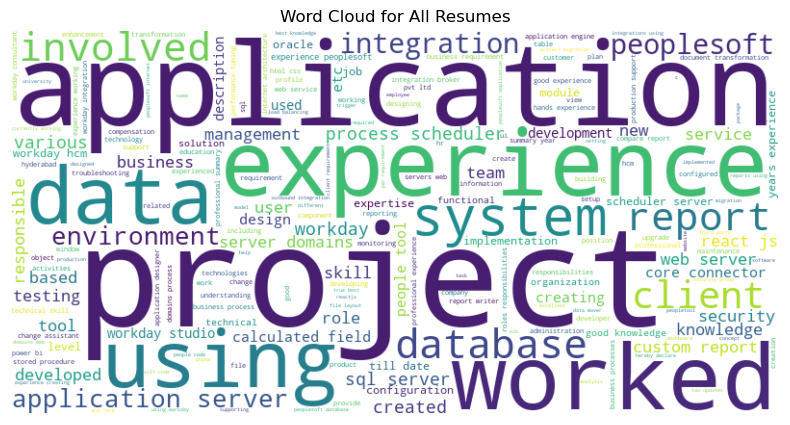

In [13]:
combined_text = ' '.join(resume['Processed_Text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Resumes')
plt.show()

#### Wordcloud based on categories

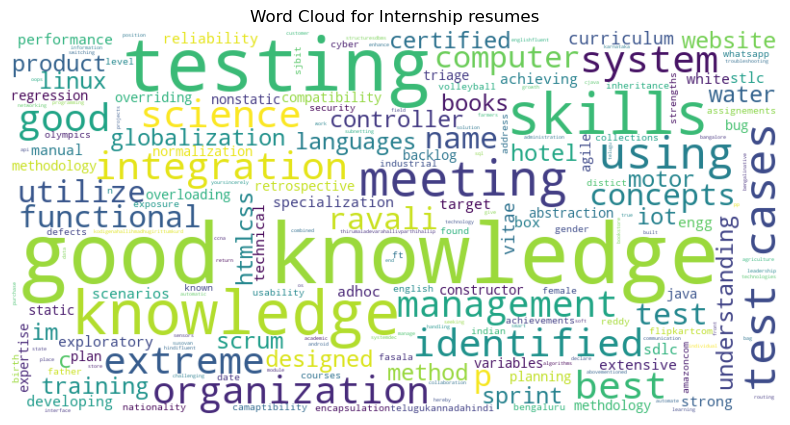

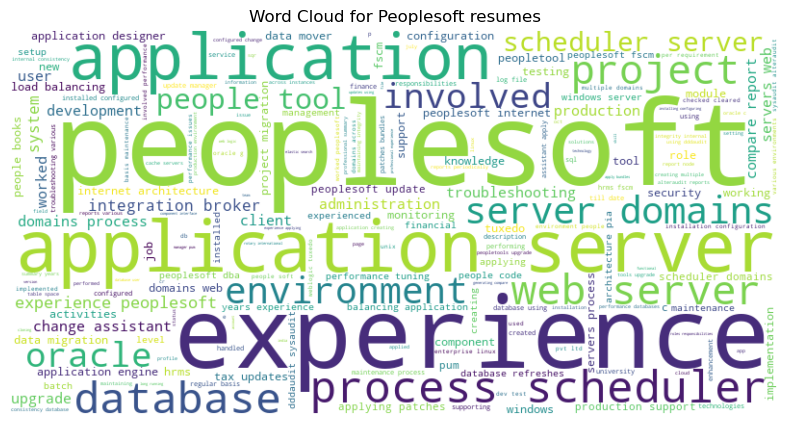

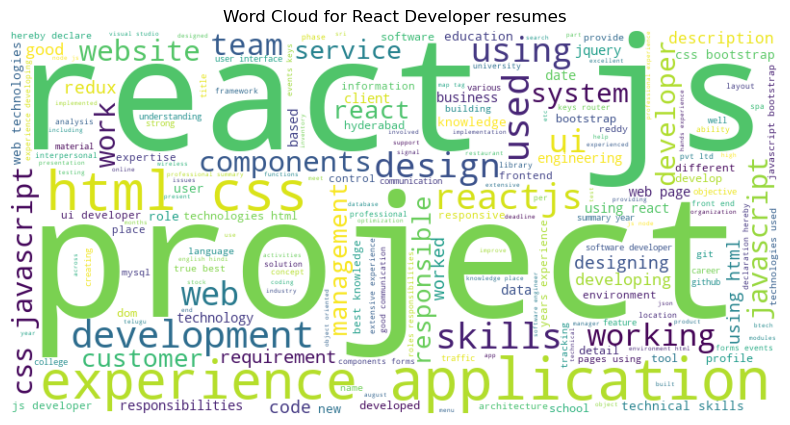

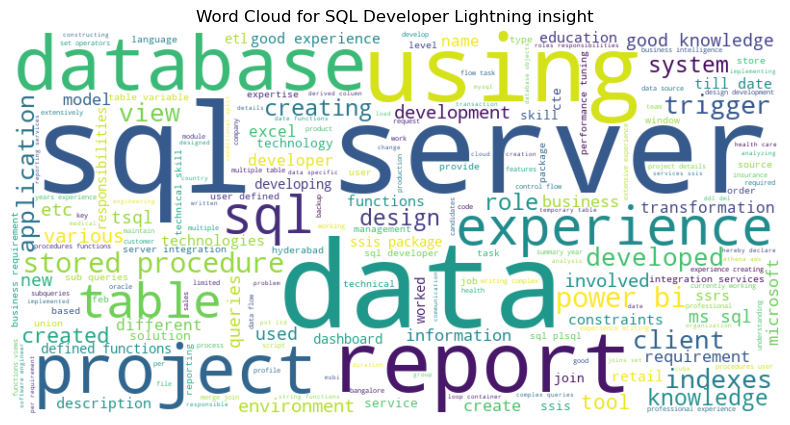

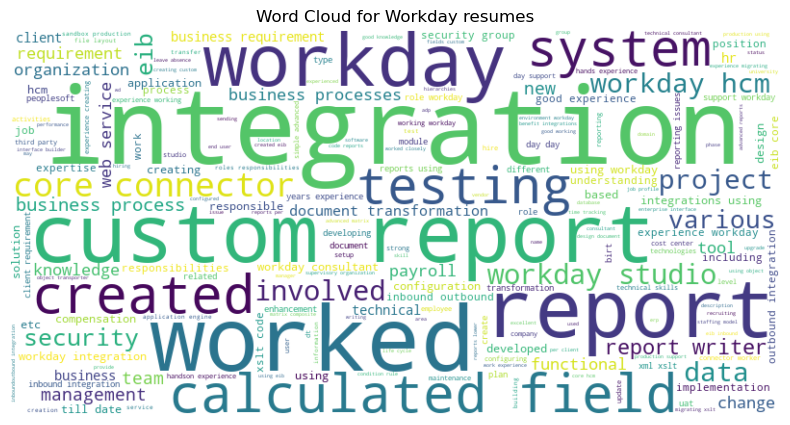

In [15]:
def generate_wordcloud(Processed_Text, Filename):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(Processed_Text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(Filename)
    plt.show()

# Filter data by category
categories = resume['Labels'].unique()

for category in categories:
    category_text = ' '.join(resume[resume['Labels'] == category]['Processed_Text'])
    generate_wordcloud(category_text, f'Word Cloud for {category}')

#### Bar plot for distribution of categories

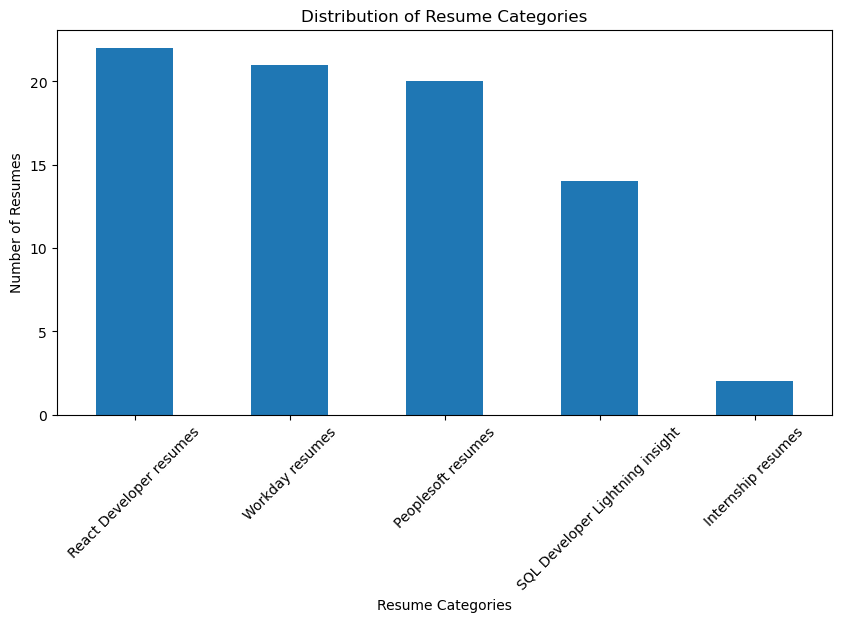

In [17]:
category_counts = resume['Labels'].value_counts()

# Create bar chart
plt.figure(figsize=(10, 5))
category_counts.plot(kind='bar')
plt.xlabel('Resume Categories')
plt.ylabel('Number of Resumes')
plt.title('Distribution of Resume Categories')
plt.xticks(rotation=45)
plt.show()

#### Histogram for length of text

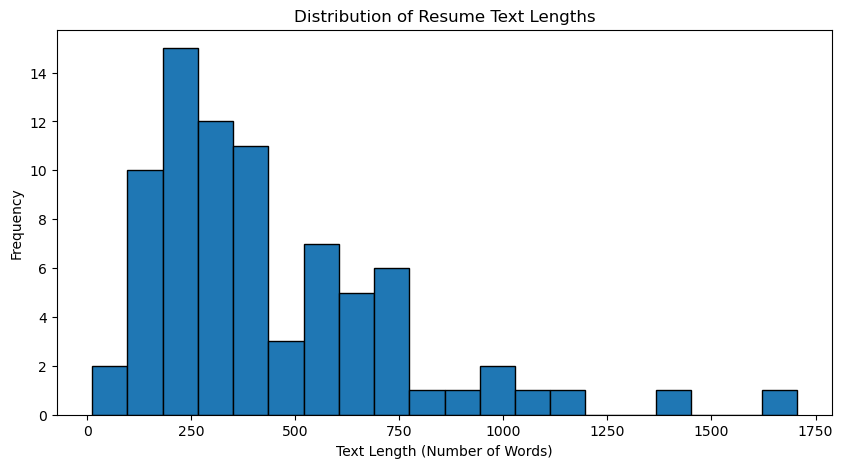

In [19]:
resume['Text_Length'] = resume['Processed_Text'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 5))
plt.hist(resume['Text_Length'], bins=20, edgecolor='black')
plt.xlabel('Text Length (Number of Words)')
plt.ylabel('Frequency')
plt.title('Distribution of Resume Text Lengths')
plt.show()

#### Scatter plot for length of text based on categories

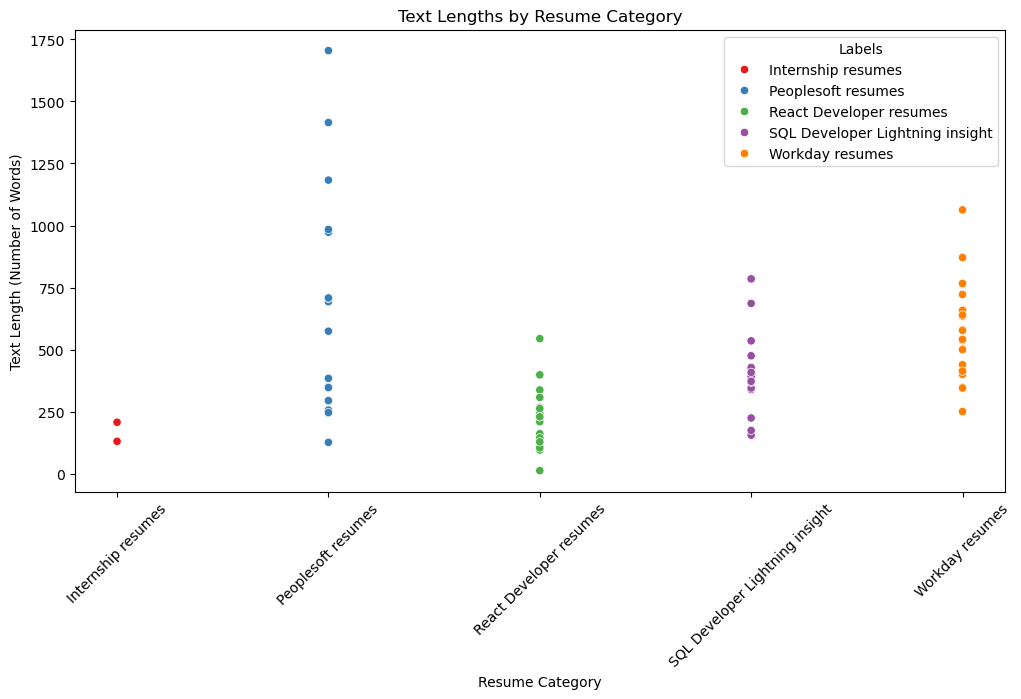

In [21]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data= resume, x='Labels', y='Text_Length', hue='Labels', palette='Set1')
plt.xlabel('Resume Category')
plt.ylabel('Text Length (Number of Words)')
plt.title('Text Lengths by Resume Category')
plt.xticks(rotation=45)
plt.show()

### TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(min_df= 2, max_features= 2000)
x = vectorizer.fit_transform(resume['Processed_Text'])
y = resume['Labels']

#### Balance the data

In [25]:
smote = SMOTE(k_neighbors=1)
x1,y1 = smote.fit_resample(x, y)

<Axes: xlabel='Labels'>

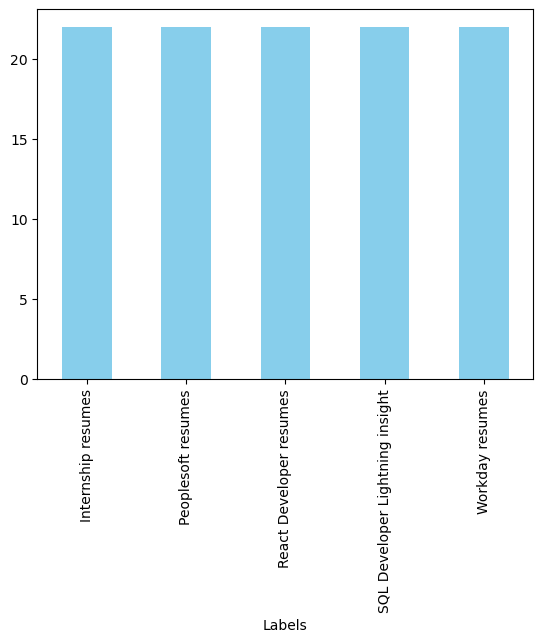

In [27]:
y1.value_counts().plot(kind='bar', color='skyblue')

In [29]:
feature_names = vectorizer.get_feature_names_out()

In [31]:
dense_matrix = x1.todense()

# Create a DataFrame
df = pd.DataFrame(dense_matrix, columns=feature_names)
df

,abilities,ability,abovementioned,absence,academic,accenture,acceptable,acceptance,access,accessibility,...,wrote,wsdl,xampp,xml,xp,xpath,xslt,xtt,year,years
0,0.0,0.000000,0.062602,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,0.0,0.000000,0.000000,0.000000,0.094931,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.086509,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,0.0,0.000000,0.030227,0.000000,0.000000,0.0,0.0,0.026461,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.009433
4,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.025368,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.010309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0.0,0.026951,0.000000,0.000000,0.007102,0.0,0.0,0.000000,0.000000,0.0,...,0.047871,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.033111,0.002625
106,0.0,0.021249,0.000000,0.000000,0.011493,0.0,0.0,0.000000,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.026106,0.004248
107,0.0,0.000000,0.000000,0.000000,0.011313,0.0,0.0,0.000000,0.000000,0.0,...,0.013401,0.0,0.0,0.000000,0.015215,0.000000,0.000000,0.0,0.000000,0.014038
108,0.0,0.032336,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.028718,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.039727,0.009280


#### Split the data

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x1, y1, test_size=0.2, random_state= 2)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(88, 2000) (22, 2000) (88,) (22,)


### Model building

In [35]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Bagging': BaggingClassifier(estimator=LogisticRegression(max_iter=1000), n_estimators=10),
    'AdaBoost': AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000), n_estimators=50),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(),
    'Ridge Classifier': RidgeClassifier()
}

In [37]:
warnings.filterwarnings("ignore")
accuracy_scores = {}
test_accuracy_scores = {}

# Evaluate each model
for name, model in models.items():
    scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    accuracy_scores[name] = scores.mean()
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_accuracy_scores[name] = test_accuracy

In [39]:
results_df = pd.DataFrame({
    'Model': list(models.keys()),
    'Train Accuracy': [accuracy_scores[name] for name in models.keys()],
    'Test Accuracy': [test_accuracy_scores[name] for name in models.keys()]
})
results_df = results_df.sort_values(by=['Train Accuracy', 'Test Accuracy'], ascending=[False, False])

# Print the sorted DataFrame
print(results_df)

                 Model  Train Accuracy  Test Accuracy
0  Logistic Regression        1.000000       1.000000
2                  SVM        1.000000       1.000000
9     Ridge Classifier        1.000000       1.000000
3        Random Forest        0.988235       0.954545
5              Bagging        0.977778       1.000000
1          Naive Bayes        0.966013       0.954545
4    Gradient Boosting        0.964706       0.863636
7        Decision Tree        0.943137       0.863636
8                  KNN        0.850327       0.545455
6             AdaBoost        0.626797       0.318182


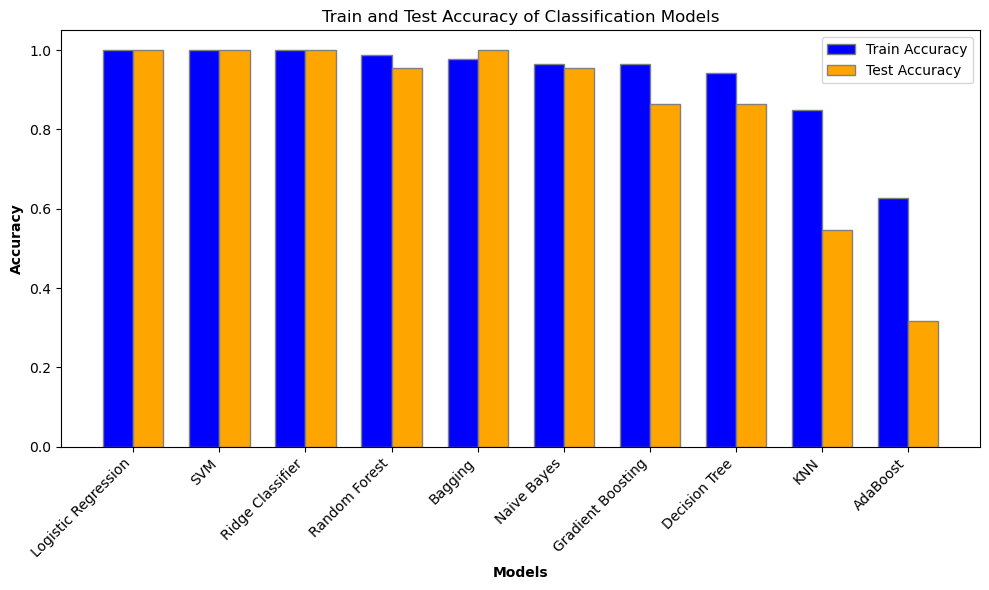

In [41]:
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.35
bar_width = 0.35

train_accuracy = results_df['Train Accuracy']
test_accuracy = results_df['Test Accuracy']
models_names = results_df['Model']

# Position of bars
r1 = np.arange(len(models_names))
r2 = [x + bar_width for x in r1]

# Plot bars
ax.bar(r1, train_accuracy, color='blue', width=bar_width, edgecolor='grey', label='Train Accuracy')
ax.bar(r2, test_accuracy, color='orange', width=bar_width, edgecolor='grey', label='Test Accuracy')

# Add labels and title
ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('Accuracy', fontweight='bold')
ax.set_title('Train and Test Accuracy of Classification Models')
ax.set_xticks([r + bar_width/2 for r in r1])
ax.set_xticklabels(models_names, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

In [43]:
final_model= LogisticRegression(max_iter= 1000)
final_model.fit(x1,y1)

LogisticRegression(max_iter=1000)

In [45]:
# Save the vectorizer
with open('Vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Save the model
with open('Resume Classification.pkl', 'wb') as file:
    pickle.dump(final_model, file)